# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


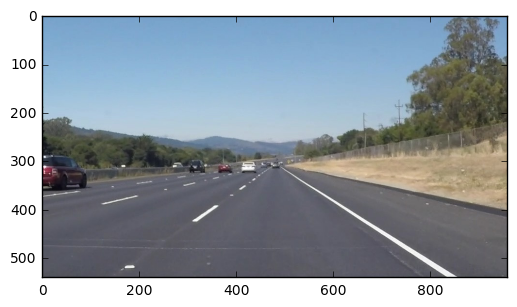

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Function to draw lines on the lanes
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_poly(img, lines, color_lane=[255, 0, 0], color_road=[0,255,0]):
    """
    Function to draw polylines on the lanes and on the road
    """
    # Pain lanes red
    for line in lines:
        for x1, y1, x2, y2 in line:
            pts = np.array([[x1-10,y1],[x1+10,y1], [x2+2,y2],[x2-2,y2]], np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(img,[pts], color_lane)

    # Paint road in green
    # pts = np.array([[lines[1][0][0]+10,y1], [lines[1][0][2]+2,y2], [lines[0][0][2]-2,y2], [lines[0][0][0]-10,y1]], np.int32)
    # pts = pts.reshape((-1,1,2))
    # cv2.fillPoly(img, [pts], color_road)

    cv2.line(img, (int((lines[0][0][0] + lines[1][0][0])/2), y1), (int((lines[0][0][2] + lines[1][0][2])/2), y2), [255,255,255], thickness=1)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, lines, figure):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    #lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
    #                        maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    if figure == "polygon":
        draw_poly(line_img, lines)
    else:
        draw_lines(line_img, lines)

    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def find_lanes(lines, ysize):
    """
    Function that extrapolate and calculates the lines returned by the Hough Transformation
    """
    
    interpolated_right = []
    interpolated_left = []
    mean_right = [0,0,0,0]
    mean_left = [0,0,0,0]
    inf = 330

    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = ((y2-y1)/(x2-x1))
            length = np.sqrt((x2-x1)**2 + (y2-y1)**2)

            # Discard angles too discrepant
            if 1 > angle > 0.5:
                interpolated_right.append([[(ysize-y2)/angle + x2, ysize, (inf-y2)/angle + x2, inf, length, angle]])
            elif -1 < angle < -0.5:
                interpolated_left.append([[(ysize-y2)/angle + x2, ysize, (inf-y2)/angle + x2, inf, length, angle]])

    # Calculate mean value for right side
    a = 0
    for y in interpolated_right:
        for x1, y1, x2, y2, length, angle in y:
            mean_right = [mean_right[0]+x1*length, mean_right[1]+y1*length,
                          mean_right[2]+x2*length, mean_right[3]+y2*length]
            a += length
    if a != 0:
        mean_right = [[[int(mean_right[0]/a),int(mean_right[1]/a),int(mean_right[2]/a),int(mean_right[3]/a)]]]
    else:
        mean_right = [[[0, 0, 0, 0]]]

    # Calculate mean value for left side
    a = 0
    for y in interpolated_left:
        for x1, y1, x2, y2, length, angle in y:
            mean_left = [mean_left[0]+x1*length,mean_left[1]+y1*length,
                          mean_left[2]+x2*length,mean_left[3]+y2*length]
            a += length
    if a != 0:
        mean_left = [[[int(mean_left[0]/a),int(mean_left[1]/a),int(mean_left[2]/a),int(mean_left[3]/a)]]]
    else:
        mean_left = [[[0, 0, 0, 0]]]

    return([mean_right[0], mean_left[0]])

def save_image(data, fn):
    """
    Save image with the original size
    """
    
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(data)
    plt.savefig(fn, dpi = height)
    plt.close()

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

solidWhiteCurve.jpg


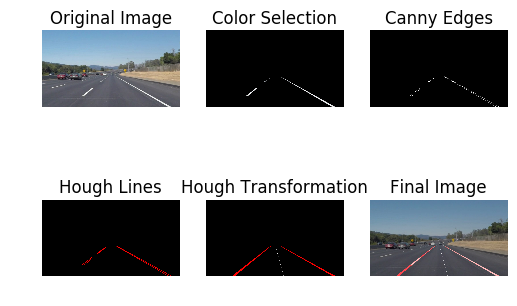

solidWhiteRight.jpg


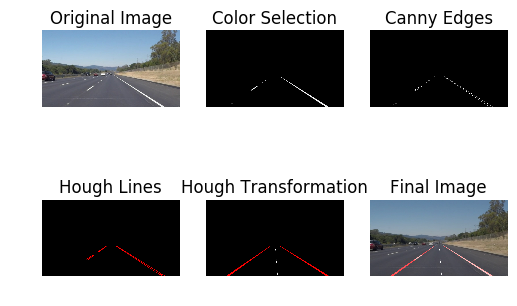

solidYellowCurve.jpg


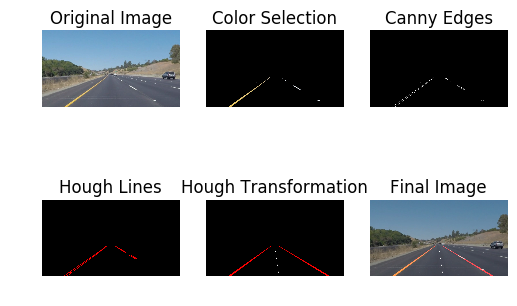

solidYellowCurve2.jpg


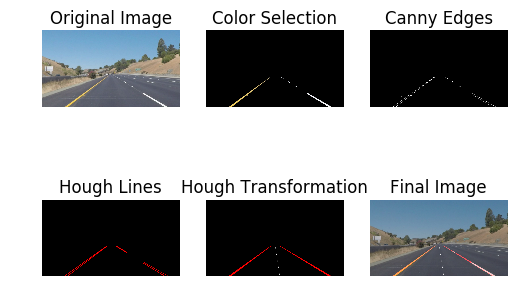

solidYellowLeft.jpg


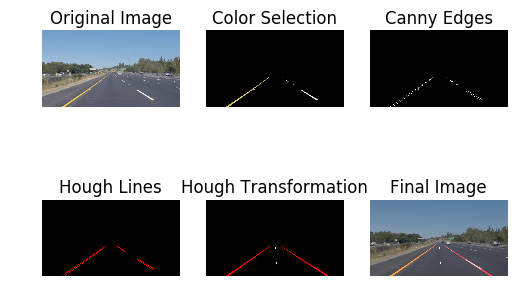

whiteCarLaneSwitch.jpg


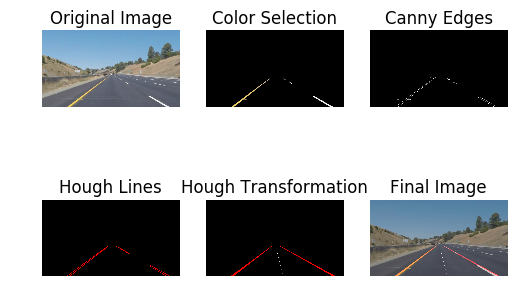

In [10]:
import os

def batch_analyze(path):

    images = filter( lambda f: not f.startswith(('Process', 'Final')), os.listdir(path))

    for i in images:
        # Open image
        image = mpimg.imread(path + i)
        print(i)

        #------------------------------Apply Color------------------------------#
        # Define color selection criteria
        red_threshold = 120
        green_threshold = 150
        blue_threshold = 50
        rgb_threshold = [red_threshold, green_threshold, blue_threshold]

        # Grab the x and y size and make a copy of the image
        ysize = image.shape[0]
        xsize = image.shape[1]
        color_select = np.copy(image)

        # Perform a "bitwise or" to mask pixels below the threshold
        color_thresholds = (image[:, :, 0] < rgb_threshold[0]) | \
                           (image[:, :, 1] < rgb_threshold[1]) | \
                           (image[:, :, 2] < rgb_threshold[2])

        # Mask color and region selection
        color_select[color_thresholds] = [0, 0, 0]

        # This time we are defining a four sided polygon to mask
        imshape = image.shape
        vertices = np.array([[(0, imshape[0]), (imshape[1] / 2 - 50, 330), (imshape[1] / 2 + 50, 330), (imshape[1], imshape[0])]], dtype=np.int32)
        masked_image = region_of_interest(color_select, vertices)

        #------------------------------Apply Canny------------------------------#
        # Convert image to gray
        gray_image = grayscale(masked_image)

        # Blur image
        blur_image = gaussian_blur(gray_image, 3)

        # Define our parameters for Canny and run it
        high_threshold, _ = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        low_threshold = 0.5 * high_threshold

        # Apply Canny
        canny_image = canny(blur_image, low_threshold, high_threshold)

        # ------------------------------Apply Hough------------------------------#
        # Define the Hough transform parameters
        rho = 1  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        threshold = 10  # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 20  # minimum number of pixels making up a line
        max_line_gap = 20  # maximum gap in pixels between connectable line segments

        lines = cv2.HoughLinesP(canny_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

        # Draw the lines on the edge image
        lines_edges = hough_lines(canny_image,rho,theta,threshold,min_line_length,max_line_gap, lines, "line")

        # ------------------------------Extrapolate lines------------------------------#
        lanes = find_lanes(lines, ysize)

        hough_image = hough_lines(canny_image,rho,theta,threshold,min_line_length,max_line_gap, lanes, "polygon")

        draw_image = weighted_img(hough_image, image)

        # ------------------------------Plot and save images------------------------------#

        plt.subplot(231)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')
        plt.subplot(232)
        plt.title('Color Selection')
        plt.imshow(masked_image)
        plt.axis('off')
        plt.subplot(233)
        plt.title('Canny Edges')
        plt.imshow(canny_image, cmap='Greys_r')
        plt.axis('off')
        plt.subplot(234)
        plt.title('Hough Lines')
        plt.imshow(lines_edges)
        plt.axis('off')
        plt.subplot(235)
        plt.title('Hough Transformation')
        plt.imshow(hough_image)
        plt.axis('off')
        plt.subplot(236)
        plt.title('Final Image')
        plt.imshow(draw_image)
        plt.axis('off')

        plt.savefig(path + 'Process ' + i)

        save_image(draw_image, path + 'Final ' + i)
        
        plt.show()

batch_analyze("test_images/")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def find_lanes(lines, ysize, image):
    global last_left_angle, last_right_angle, last_mean_left, last_mean_right
    """
    Function that extrapolate and calculates the lines returned by the Hough Transformation

    :param lines: the output from the Hough Transformation
    :return: two lines, one for the right and one for the left lane
    """
    interpolated_right = []
    interpolated_left = []
    mean_right = [0,0,0,0]
    mean_left = [0,0,0,0]
    inf = 330
    angle_dif = 0.2

    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = ((y2-y1)/(x2-x1))
            length = np.sqrt((x2-x1)**2 + (y2-y1)**2)

            if angle > 0.5:
                interpolated_right.append([[(ysize-y2)/angle + x2, ysize, (inf-y2)/angle + x2, inf, length, angle]])
            elif angle < -0.5:
                interpolated_left.append([[(ysize-y2)/angle + x2, ysize, (inf-y2)/angle + x2, inf, length,angle]])

    # Calculate mean value for right side
    a = 0
    count = 0
    right_angle = 0
    for y in interpolated_right:
        for x1, y1, x2, y2, length, angle in y:
            if abs(angle/last_right_angle - 1) < angle_dif or last_right_angle == 0:
                mean_right = [mean_right[0]+x1*length, mean_right[1]+y1*length,
                              mean_right[2]+x2*length, mean_right[3]+y2*length]
                a += length
                count += 1
                right_angle += angle

    if a != 0:
        mean_right = [[[int(mean_right[0]/a),int(mean_right[1]/a),int(mean_right[2]/a),int(mean_right[3]/a)]]]
        last_right_angle = right_angle / count
        last_mean_right = mean_right
    else:
        P1.save_image(image, 'video_images/' + str(randint(10000,99999)) + '.jpeg')
        mean_right = last_mean_right

    # Calculate mean value for left side
    a = 0
    count = 0
    left_angle = 0
    for y in interpolated_left:
        for x1, y1, x2, y2, length, angle in y:
            if abs(angle/last_left_angle - 1) < angle_dif or last_left_angle == 0:
                mean_left = [mean_left[0]+x1*length,mean_left[1]+y1*length,
                              mean_left[2]+x2*length,mean_left[3]+y2*length]
                a += length
                count += 1
                left_angle += angle

    if a != 0:
        mean_left = [[[int(mean_left[0]/a),int(mean_left[1]/a),int(mean_left[2]/a),int(mean_left[3]/a)]]]
        last_left_angle = left_angle/count
        last_mean_left = mean_left
    else:
        P1.save_image(image, 'video_images/' + str(randint(10000,99999)) + '.jpeg')
        mean_left = last_mean_left

    return([mean_right[0], mean_left[0]])

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    #------------------------------Apply Color------------------------------#
    # Define color selection criteria
    red_threshold = 120
    green_threshold = 150
    blue_threshold = 50
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)

    # Perform a "bitwise or" to mask pixels below the threshold
    color_thresholds = (image[:, :, 0] < rgb_threshold[0]) | \
                       (image[:, :, 1] < rgb_threshold[1]) | \
                       (image[:, :, 2] < rgb_threshold[2])

    # Mask color and region selection
    color_select[color_thresholds] = [0, 0, 0]

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1] / 2 - 50, 330), (imshape[1] / 2 + 50, 330), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(color_select, vertices)

    #------------------------------Apply Canny------------------------------#
    # Convert image to gray
    gray_image = grayscale(masked_image)

    # Blur image
    blur_image = gaussian_blur(gray_image, 3)

    # Define our parameters for Canny and run it
    high_threshold, _ = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_threshold = 0.5 * high_threshold

    # Apply Canny
    canny_image = canny(blur_image, low_threshold, high_threshold)

    # ------------------------------Apply Hough------------------------------#
    # Define the Hough transform parameters
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments

    lines = cv2.HoughLinesP(canny_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    # ------------------------------Extrapolate lines------------------------------#
    lanes = find_lanes(lines, ysize, image)

    hough_image = hough_lines(canny_image,rho,theta,threshold,min_line_length,max_line_gap, lanes, 'polygon')

    draw_image = weighted_img(hough_image, image)

    return draw_image

last_right_angle = 0
last_left_angle = 0

Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:07<00:00, 29.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.17 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:22<00:00, 30.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 23.1 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:16<00:00, 16.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 18.2 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))